# Generate the figures

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load the data

In [2]:
# Define the data and figure folder.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"

In [3]:
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

In [4]:
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
mdata.obsm["X_mofa"] = mofa_model.get_factors()
mdata.uns = {}


## Plot the embedding

In [5]:
joint_embedding = ad.AnnData(mdata.obsm["X_mofa"], obs=mdata.obs)
joint_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

In [6]:
sc.pp.neighbors(joint_embedding, n_neighbors=25)
sc.tl.umap(joint_embedding)

In [7]:
sc.tl.leiden(joint_embedding, resolution=.2, key_added="leiden")
sc.tl.leiden(joint_embedding, resolution=3, key_added="leiden_precise")

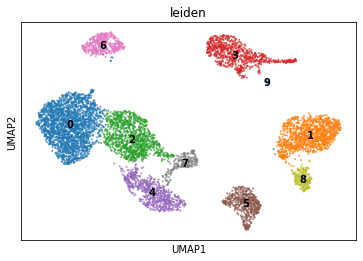

In [8]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, legend_loc="on data", save="tea_leiden_mofa.pdf")

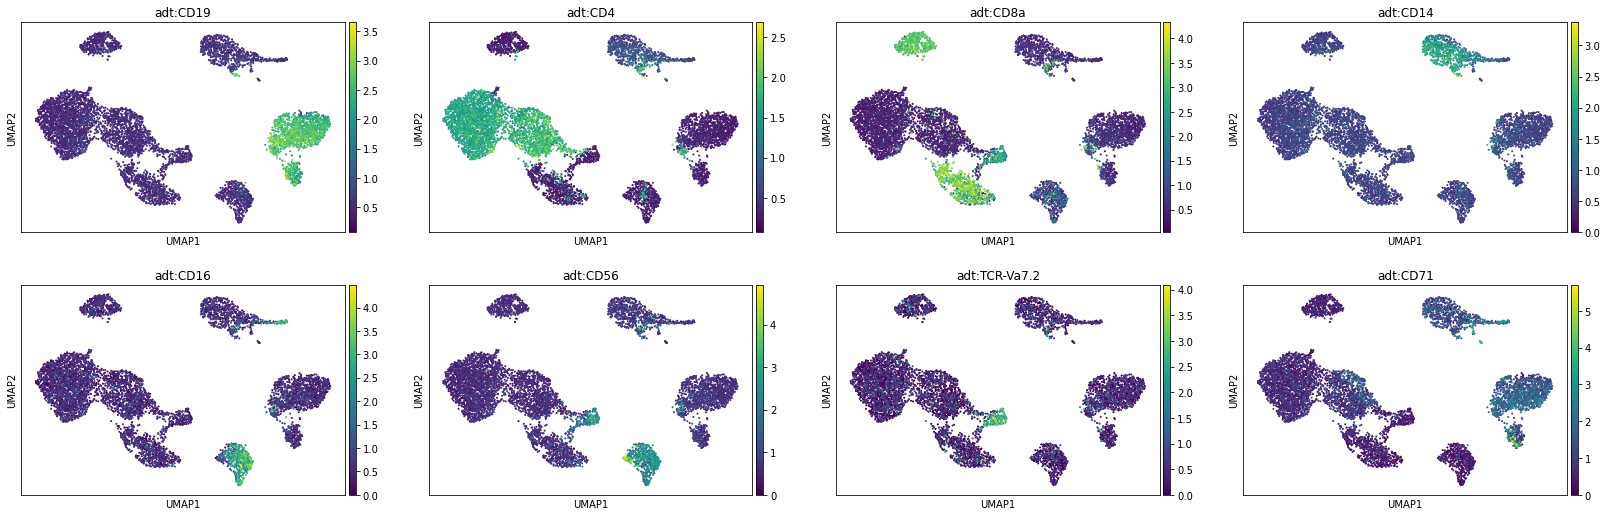

In [9]:
sc.pl.umap(
    joint_embedding,
    color=[
        "adt:CD19", # B cells
        "adt:CD4", # CD4 T cells
        "adt:CD8a", # CD8 T cells
        "adt:CD14", # Monocytes
        "adt:CD16", # Monocytes
        "adt:CD56", # NK cells
        "adt:TCR-Va7.2", # MAIT T cells
        "adt:CD71", # Erythroid cells
    ],
)

In [11]:
cluster_names = {
    1: "B cells",
    8: "B cells",
    0: "CD4 T cells",
    2: "CD4 T cells",
    4: "CD8 T cells",
    6: "CD8 T cells",
    3: "Monocytes",
    5: "NK cells",
    7: "MAIT T cells",
    9: "Erythroid cells",
}
joint_embedding.obs["leiden"] = [cluster_names[c] for c in joint_embedding.obs["leiden"].cat.codes]

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


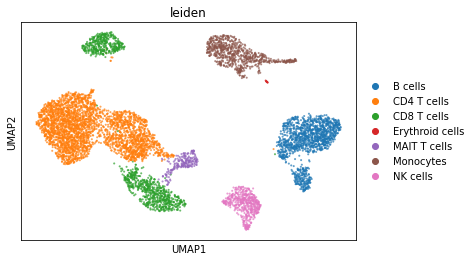

In [12]:
sc.pl.umap(joint_embedding, color="leiden", alpha=.7, save="tea_leiden.pdf")

In [13]:
sc.tl.dendrogram(joint_embedding, groupby="leiden_precise")
joint_embedding.obs["leiden_precise"] = joint_embedding.obs["leiden_precise"].cat.rename_categories(np.argsort(joint_embedding.uns["dendrogram_leiden_precise"]["categories_idx_ordered"]))
joint_embedding = joint_embedding[joint_embedding.obs["leiden_precise"].argsort()]

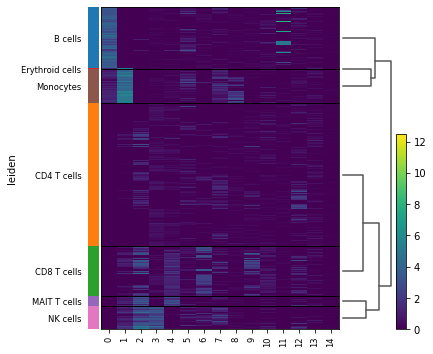

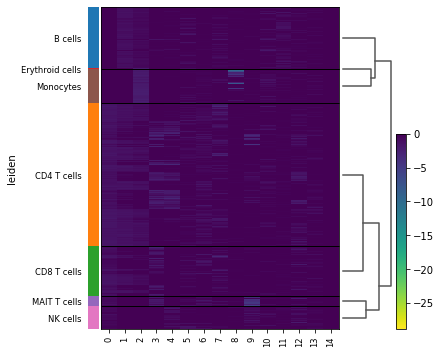

In [20]:
sc.tl.dendrogram(joint_embedding, groupby="leiden")
sc.pl.heatmap(
    joint_embedding,
    var_names=joint_embedding.var_names,
    groupby="leiden",
    dendrogram=True,
    vmin=0,
)
sc.pl.heatmap(
    joint_embedding,
    var_names=joint_embedding.var_names,
    groupby="leiden",
    dendrogram=True,
    vmax=0,
    cmap="viridis_r"
)


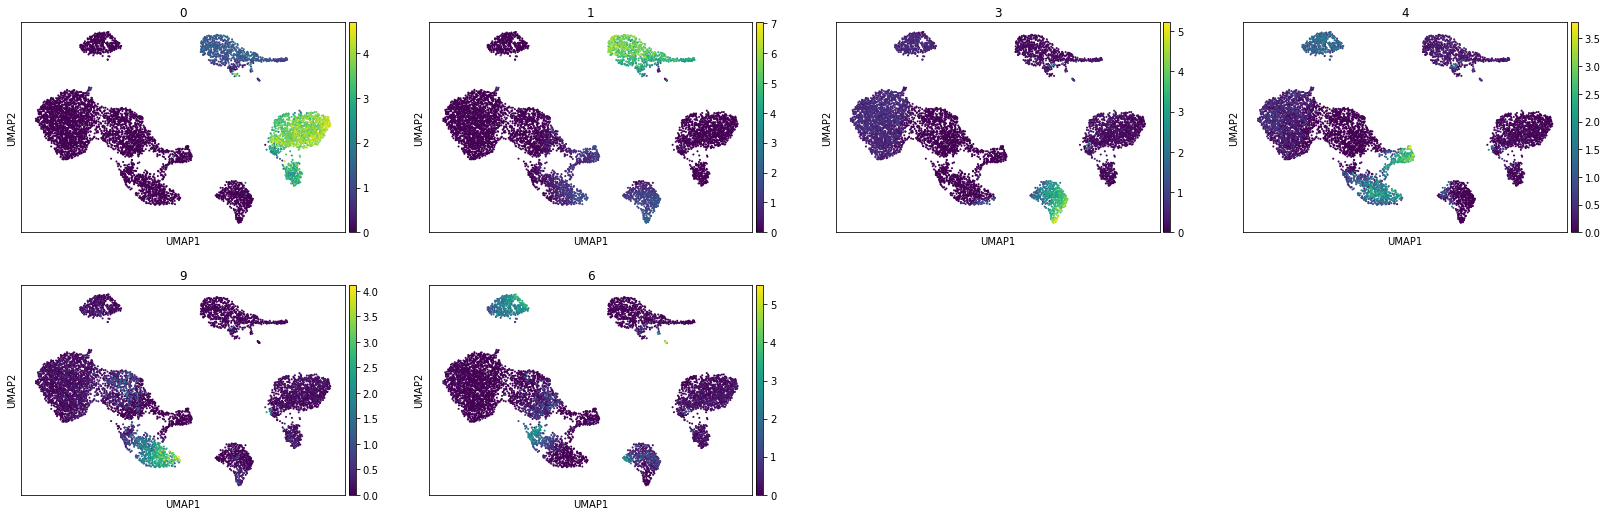

In [40]:
sc.pl.umap(
    joint_embedding,
    color=[
        "0", # B cells
        "1", # Monocytes
        "3", # NK cells
        "4", # MAIT T cells
        "9", # CD8 T cells
        "6", # Erythroid cells
    ],
    vmin=0
)

## Plot dictionary

In [33]:
H = {
    "H_rna": mofa_model.get_weights("rna"),
    "H_atac": mofa_model.get_weights("atac"),
    "H_adt": mofa_model.get_weights("adt")
}

In [38]:
def plot_proteins(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_adt"][:, dim].argsort()[::-1]
    labels = mdata["adt"].var_names.str.replace("adt:", "")[idx]
    ax.bar(labels, H["H_adt"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    ax.set_xticklabels(labels, rotation=90)
    plt.show()

def plot_genes(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_rna"][:, dim].argsort()[::-1]
    ax.plot(H["H_rna"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def plot_peaks(dim):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    idx = H["H_atac"][:, dim].argsort()[::-1]
    ax.plot(H["H_atac"][idx, dim])
    ax.set_title(f'Plotting dim {str(dim)}')
    plt.show()

def top_proteins(dim):
    top_idx = H["H_adt"][:, dim].argsort()[::-1][:10]
    return mdata["adt"].var_names.str.replace("adt:", "")[top_idx].to_numpy(dtype=str)

def top_genes(dim):
    top_idx = H["H_rna"][:, dim].argsort()[::-1][:100]
    return mdata["rna"].var_names.str.replace("rna:", "")[top_idx].to_numpy(dtype=str)

def top_peaks(dim):
    top_idx = H["H_atac"][:, dim].argsort()[::-1][:100]
    return mdata["atac"].var_names.str.replace("atac:", "")[top_idx].to_numpy(dtype=str)

<ipython-input-38-512fa0c373ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


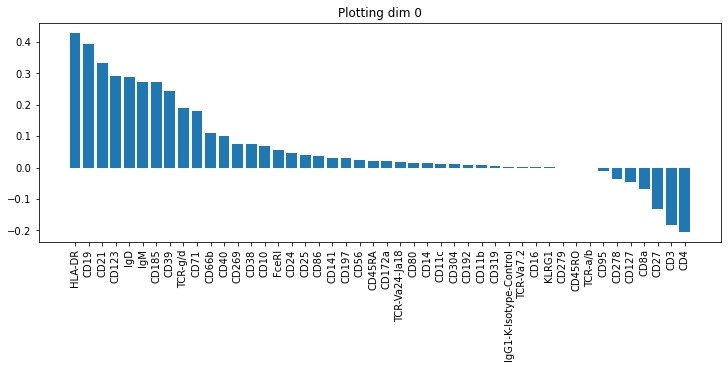

Top proteins: HLA-DR, CD19, CD21, CD123, IgD, IgM, CD185, CD39, TCR-g/d, CD71
Top genes: BANK1, AFF3, LYN, SIPA1L1, ARHGAP24, CD74, ADAM28, TRIO, EIF2AK3, CDK14
Top peaks: chr19:2677615-2682203, chr6:167112403-167115173, chr6:150598982-150601209, chr2:231670897-231673760, chr15:74382031-74386562, chr9:123337879-123341080, chr6:33027473-33030513, chr22:44023538-44027752, chr4:90126889-90129554, chr10:48670854-48673284


<ipython-input-38-512fa0c373ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


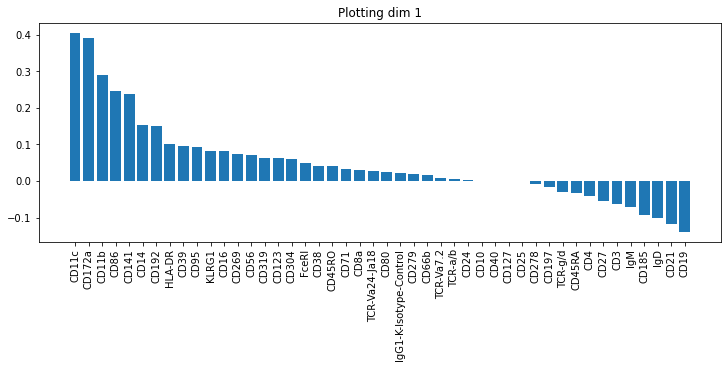

Top proteins: CD11c, CD172a, CD11b, CD86, CD141, CD14, CD192, HLA-DR, CD39, CD95
Top genes: ZEB2, NEAT1, ARHGAP26, ITGAX, RBM47, LRMDA, JARID2, MYO9B, GAB2, MYO1F
Top peaks: chr4:7646534-7651079, chr20:40687498-40690954, chr15:70507511-70510172, chr3:46088920-46091418, chr7:151795424-151798297, chr12:54382824-54386099, chr7:101717093-101718814, chr20:10671338-10675134, chr20:50273811-50276595, chr17:74512290-74515467


<ipython-input-38-512fa0c373ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


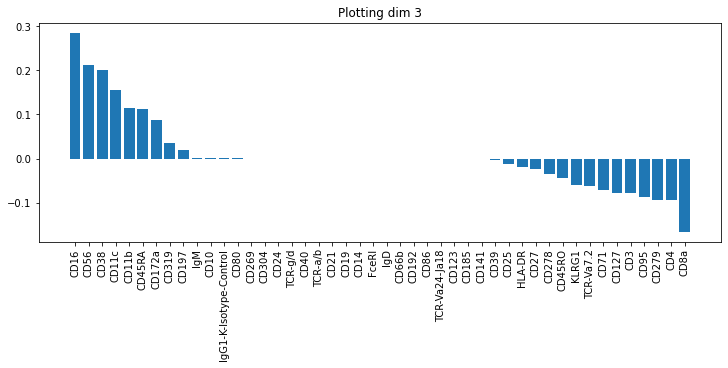

Top proteins: CD16, CD56, CD38, CD11c, CD11b, CD45RA, CD172a, CD319, CD197, IgM
Top genes: CD247, LYN, TXK, MCTP2, GNLY, PTPN12, BNC2, AOAH, YES1, FNDC3B
Top peaks: chr3:143118836-143123737, chr6:161241925-161243801, chr22:23263648-23264676, chr1:184386284-184389026, chr8:106269588-106271748, chr17:1119906-1121262, chr17:74512290-74515467, chr4:8408925-8410213, chr9:136315992-136317134, chr16:57666950-57668871


<ipython-input-38-512fa0c373ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


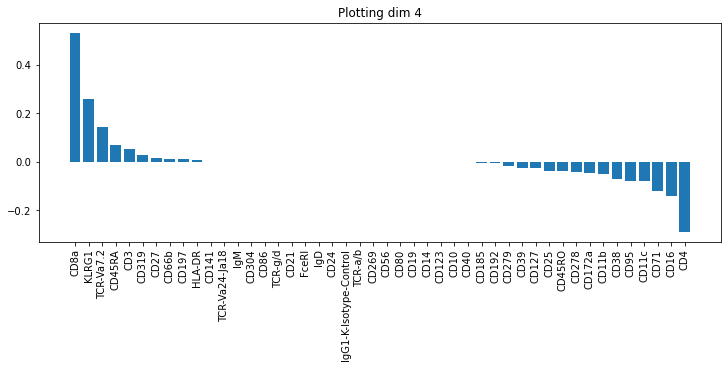

Top proteins: CD8a, KLRG1, TCR-Va7.2, CD45RA, CD3, CD319, CD27, CD66b, CD197, HLA-DR
Top genes: SLC7A5, CD8A, ARHGAP26, CRTAM, HSPH1, HSP90AA1, BACH2, YBX3, PTK2B, BCL11B
Top peaks: chr2:86785355-86787189, chr11:66315532-66318943, chr2:86807275-86809907, chr12:10721324-10723787, chr14:101711255-101714135, chr17:3794780-3797254, chr2:86788875-86791965, chr14:92530957-92532561, chr2:29009466-29013363, chr2:86825406-86826794


<ipython-input-38-512fa0c373ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


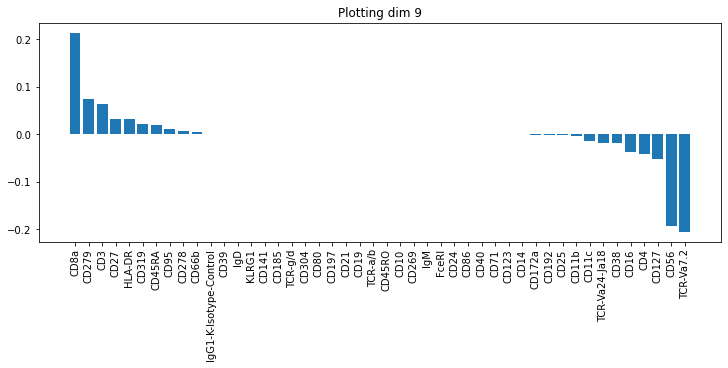

Top proteins: CD8a, CD279, CD3, CD27, HLA-DR, CD319, CD45RA, CD95, CD278, CD66b
Top genes: ZEB2, PPP1R16B, CEMIP2, PIK3R1, MCOLN2, AOAH, EZR, ATXN1, KLRK1, RNF19A
Top peaks: chr16:23482611-23483954, chr4:6198109-6202085, chr14:105855839-105860468, chr6:16420079-16421821, chr15:65512690-65513493, chr8:100409524-100411815, chr12:22333811-22336093, chr2:86825406-86826794, chr16:84593648-84595553, chr10:113960418-113962146


<ipython-input-38-512fa0c373ef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


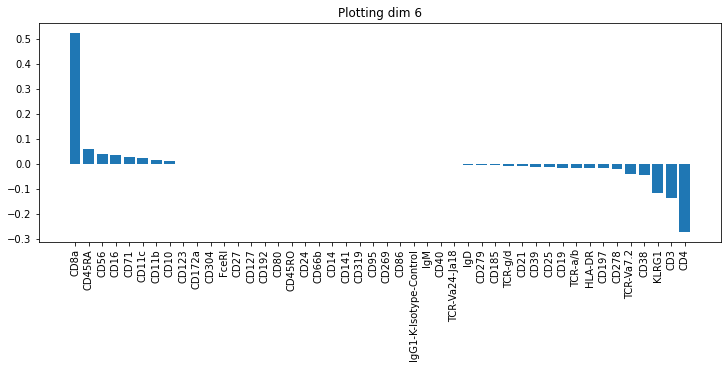

Top proteins: CD8a, CD45RA, CD56, CD16, CD71, CD11c, CD11b, CD10, CD123, CD172a
Top genes: NELL2, KLRK1, LMNA, YBX3, RUNX3, NRCAM, SNED1, NCALD, ITGB1, NR4A2
Top peaks: chr2:86785355-86787189, chr11:66315532-66318943, chr19:50657795-50659751, chr12:10721324-10723787, chr20:48768708-48770140, chr2:241034990-241037472, chr2:86807275-86809907, chr12:10394452-10396206, chr10:132158175-132162575, chr1:1370610-1373519


In [41]:
for dim in [0, 1, 3, 4, 9, 6]:
    plot_proteins(dim)
    print("Top proteins:", ", ".join(top_proteins(dim)))
    print("Top genes:", ", ".join(top_genes(dim)[:10]))
    print("Top peaks:", ", ".join(top_peaks(dim)[:10]))

## Enrich

In [42]:
import gget
import pyperclip

In [50]:
pyperclip.copy("\n".join(top_genes(0)))

In [46]:
def enrich(dim: int, database: str):
    idx = H["H_rna"][:, dim].argsort()[::-1]
    enr = gget.enrichr(top_genes(dim), database)
    enr["min_log_adj_p_val"] = -np.log10(enr["adj_p_val"])
    sns.scatterplot(data=enr.head(), x='min_log_adj_p_val', y='path_name', s=150)
    plt.show()

Mon Aug 29 17:35:10 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:10 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


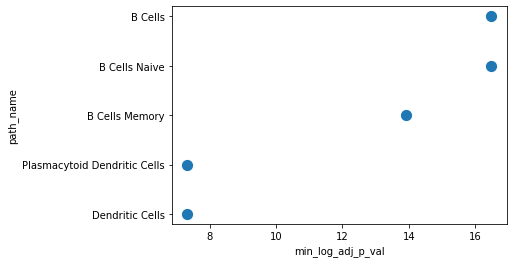

Mon Aug 29 17:35:11 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:11 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


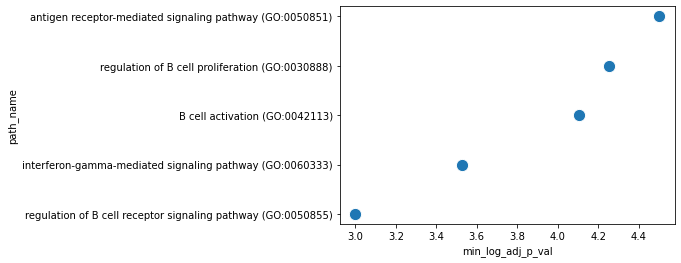

In [47]:
enrich(0, "celltypes")
enrich(0, "ontology")

Mon Aug 29 17:35:40 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:40 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


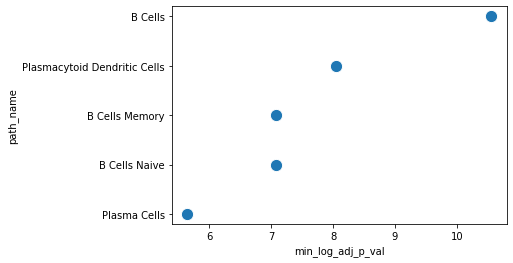

Mon Aug 29 17:35:41 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Mon Aug 29 17:35:41 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


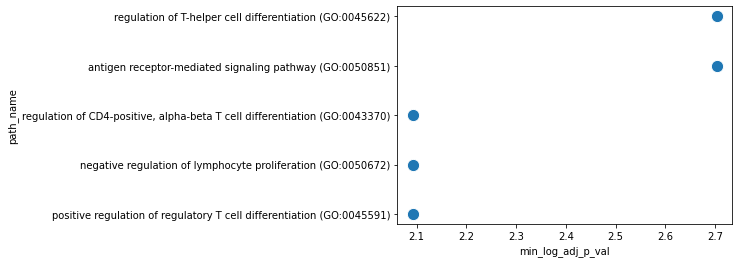

In [ ]:
enrich(11, "celltypes")
enrich(11, "ontology")

## Motifs

In [52]:
H_rescaled = H["H_atac"] / H["H_atac"].sum(1).reshape(-1, 1)
for dim in range(15):
    idx = H_rescaled[:, dim].argsort()[::-1][:1_000]
    mdata["atac"].var["top_in_dim_" + str(dim)] = False
    mdata["atac"].var.loc[
        mdata["atac"].var_names[idx].to_numpy(dtype=str),
        "top_in_dim_" + str(dim),
    ] = True


<ipython-input-52-7d77b6879b8c>:1: RuntimeWarning: invalid value encountered in true_divide
  H_rescaled = H["H_atac"] / H["H_atac"].sum(1).reshape(-1, 1)


In [53]:
mdata["atac"].var.to_csv('/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/top_var_mofa.csv')

In [107]:
# Run R

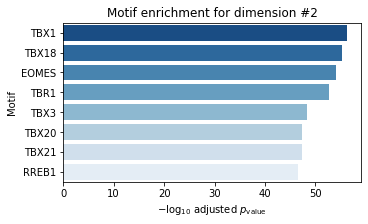

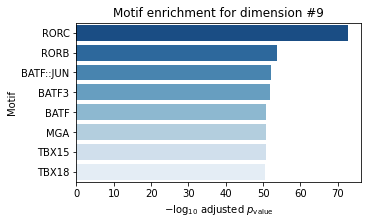

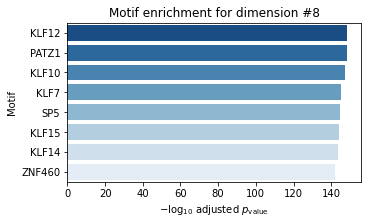

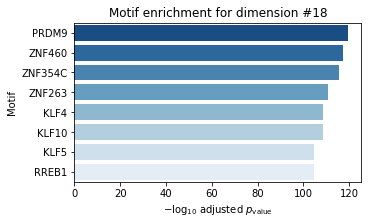

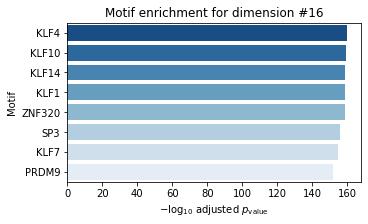

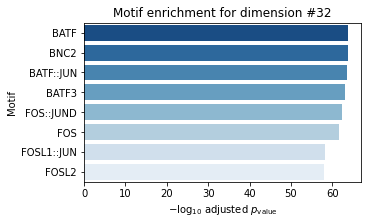

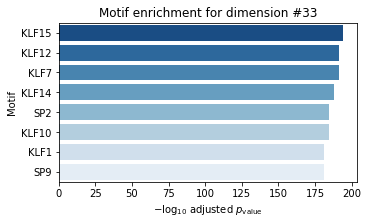

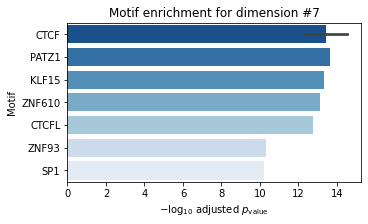

In [410]:
for dim in [2, 9, 8, 18, 16, 32, 33, 7]:

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)

    motifs = pd.read_csv(
        f"/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/motifs_mofa/motifs_{dim}.csv",
        index_col=0,
    )
    motifs = motifs[motifs["motif"].str.startswith("MA")]
    motifs["minlogp.adjust"] = -np.log10(motifs["p.adjust"])
    sns.barplot(
        data=motifs[:8],
        x="minlogp.adjust",
        y="motif.name",
        ax=ax,
        palette="Blues_r",
    )
    ax.set_title(f"Motif enrichment for dimension #{dim}")
    ax.set_xlabel(r"$-\log_{10}~\mathrm{adjusted}~p_{\mathrm{value}}$")
    ax.set_ylabel("Motif")

    plt.show()
